<h1><center>Customer Churn Prediction with XGBoost on Imbalanced Telecom Data</center>

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Load the data
df = pd.read_excel("data/CustomerChurn.xlsx")

# Exploratory Data Analysis

In [4]:
# Show the data table
df

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,810338,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,230811,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,155157,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,731782,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
# Print (rows, columns) for the data
df.shape

(7043, 21)

In [6]:
# Print the List of Columns
list(df.columns)

['LoyaltyID',
 'Customer ID',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Tenure',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Monthly Charges',
 'Total Charges',
 'Churn']

The data is sourced from IBM's Base Samples. It contains 7043 rows and 19 columns. It is fictional data on customer churn for a telecom company.

More information about the data can be found here: https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

## Unique values

In [7]:
# Print all unique values for each column
for col in df.columns:
    print(f"{col}:")
    print(df[col].unique())

LoyaltyID:
[318537 152148 326527 ... 155157 731782 353947]
Customer ID:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Senior Citizen:
['No' 'Yes']
Partner:
['Yes' 'No']
Dependents:
['No' 'Yes']
Tenure:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Phone Service:
['No' 'Yes']
Multiple Lines:
['No phone service' 'No' 'Yes']
Internet Service:
['DSL' 'Fiber optic' 'No']
Online Security:
['No' 'Yes' 'No internet service']
Online Backup:
['Yes' 'No' 'No internet service']
Device Protection:
['No' 'Yes' 'No internet service']
Tech Support:
['No' 'Yes' 'No internet service']
Streaming TV:
['No' 'Yes' 'No internet service']
Streaming Movies:
['No' 'Yes' 'No internet service']
Contract:
['Month-to-month' 'One year' 'Two year']
Paperless Billing:
['Yes' 'No']
Payment Method:
['Electr

Some of the features have possible values that are dependent on another feature. For example, Multiple Lines has 'No phone service' as a possible value. When it takes values of 'Yes' or 'No', it implies the user has phone service. 

When modeling, 'Phone Service' and 'Internet Service' woiuld have to be excluded in order to prevent issues with independence/autocorrelation. Considering how phone service and internet service could be determined from other columns, it would probably be better to remove those columns entirely.

## Data types

In [8]:
# Check data types for each column
df.dtypes

LoyaltyID              int64
Customer ID           object
Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn                 object
dtype: object

Most of the data is in object type. This makes sense as most of the data is categorical. 

LoyaltyID and Tenure are in int64. LoyaltyID shoulde be changed to an object or string because it is an identifier rather than a numerical value.

Total Charges is an object, while Monthly Charges is in float64. Total Charges should be changed to float64 since the values are supposed to be numeric.

In [9]:
# Convert 'Total Charges' to numeric, coercing errors to NaN
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

In [10]:
# Convert LoyaltyID to an object
df['LoyaltyID'] = df['LoyaltyID'].astype('object')

In [11]:
# Verify that the data types were changed for 'LoyaltyID' and 'Total Charges'
df.dtypes

LoyaltyID             object
Customer ID           object
Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn                 object
dtype: object

LoyaltyID and Total Charges were successfully changed into the appropriate data types.

## Handle Missing Values

In [12]:
# Check for nulls
print('Number of Nulls:')
print(int(df.isna().sum().sum()))

Number of Nulls:
11


In [13]:
# Find all rows with missing values
df[df.isna().any(axis=1)]

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,344543,4472-LVYGI,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,150036,3115-CZMZD,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,497688,5709-LVOEQ,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,158969,4367-NUYAO,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,470044,1371-DWPAZ,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,937662,7644-OMVMY,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,821083,3213-VVOLG,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,947028,2520-SGTTA,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,135257,2923-ARZLG,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,317862,4075-WKNIU,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


There are only null valuies for the Total Charges column. Since there happens to be values for the Monthly Charges for each row, we can impute the missing values with the corresponding Monthly Charges. What happened was probably that the users are new and just had their first Monthly Charge. We will impute the missing values with the corresponding Monthly Charge.

In [14]:
# Impute nulls with Monthly Charges
df.loc[df['Total Charges'].isna(), 'Total Charges'] = df.loc[df['Total Charges'].isna(), 'Monthly Charges']

In [15]:
# Check for nulls
print('Number of Nulls:')
print(int(df.isna().sum().sum()))

Number of Nulls:
0


There are no rows with missing values in the data anymore. To further verify if the imputation was done correctly, let's find the rows that had their missing values imputed. 

We will use the LoyaltyID of those rows to filter the data.

In [16]:
# Check some of the previous rows with missing values
df[df['LoyaltyID'].astype(str).isin(['344543', '150036', '497688'])]

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,344543,4472-LVYGI,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,No
753,150036,3115-CZMZD,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,20.25,No
936,497688,5709-LVOEQ,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,80.85,No


Here are some of the rows, and we can see that the Total Charges are now the same as the Monthly Charges for these users.

## Remove Any Extra White Space in the Data

In [17]:
# Select columns that are objects
cat_cols = df.select_dtypes(include=['object']).columns

# Remove any extra white space
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype(str).str.strip())

## Check for Duplicate Rows

In [18]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


## Summary Statistics

In [19]:
# Summary Statistics
df.describe()

,Tenure,Monthly Charges,Total Charges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.798992
std,24.559481,30.090047,2266.730170
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


The Summary Statistics table is only printed for the 3 non-object columns. 

From the means, mins, and maxes, the values seem similar in magnitude have significant differences in magnitude between Total Charges and the other 2 features. 

Tenure, although hard to tell just looking at feature name, is in months. The value of 72 represents 6 years. Half of the company's customers have stayed with them for around 2 and a half years.

In [20]:
# Filter the data for Total Charges over $8000 and having 72 months of Tenure
df[(df['Total Charges'] > 8000) & (df['Tenure'] == 72)]

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
193,113529,9680-NIAUV,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,No,Credit card (automatic),109.70,8129.30,No
198,868830,7255-SSFBC,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),112.25,8041.65,No
369,116254,3520-FJGCV,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),112.60,8126.65,No
437,173159,4376-KFVRS,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,No
464,289423,1480-BKXGA,Yes,Yes,No,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,8404.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,456645,2193-SFWQW,No,Yes,Yes,72,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),111.95,8033.10,No
6118,717232,9924-JPRMC,No,No,No,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.20,8547.15,No
6403,183948,3258-ZKPAI,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.60,8337.45,No
6728,382019,2380-DAMQP,No,Yes,No,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Electronic check,115.15,8349.70,No


In [21]:
8684/72

120.61111111111111

The range of values look reasonable. This is true even for the values of Total Charges at or close to the max. These rows translate to around $120 per month over their tenure.

Considering how reasonable the values appear, we will consider the data free from outliers and refrain from further action in order to preserve data integrity. We will also be using XGBoost for the model, which is robust to outliers when used for classification tasks such as our Customer Churn Prediction.

## Correlation Heatmap

<Axes: >

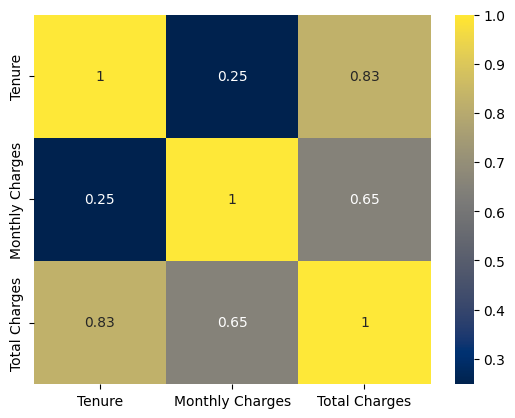

In [22]:
# Select columns that are not objects
num_cols = df.select_dtypes(exclude=['object']).columns

# Find the correlation matrix
corr = df[num_cols].corr()

# Construct the Correlation Heatmap
sns.heatmap(corr, annot=True, fmt='.2g', cmap='cividis')

Tenure has high 0.83 correlation with Total Charges, which is reasonable considering the longer a customer stays with the company, the larger the accumulation of their charges. 

Monthly Charges has a moderate 0.65 correlation with Total Charges. This likely means that customers have a tendency to change their plans, and by extension, their Monthly Charges rather than sticking to the same plan. 

## Plot Categorical Variable Counts

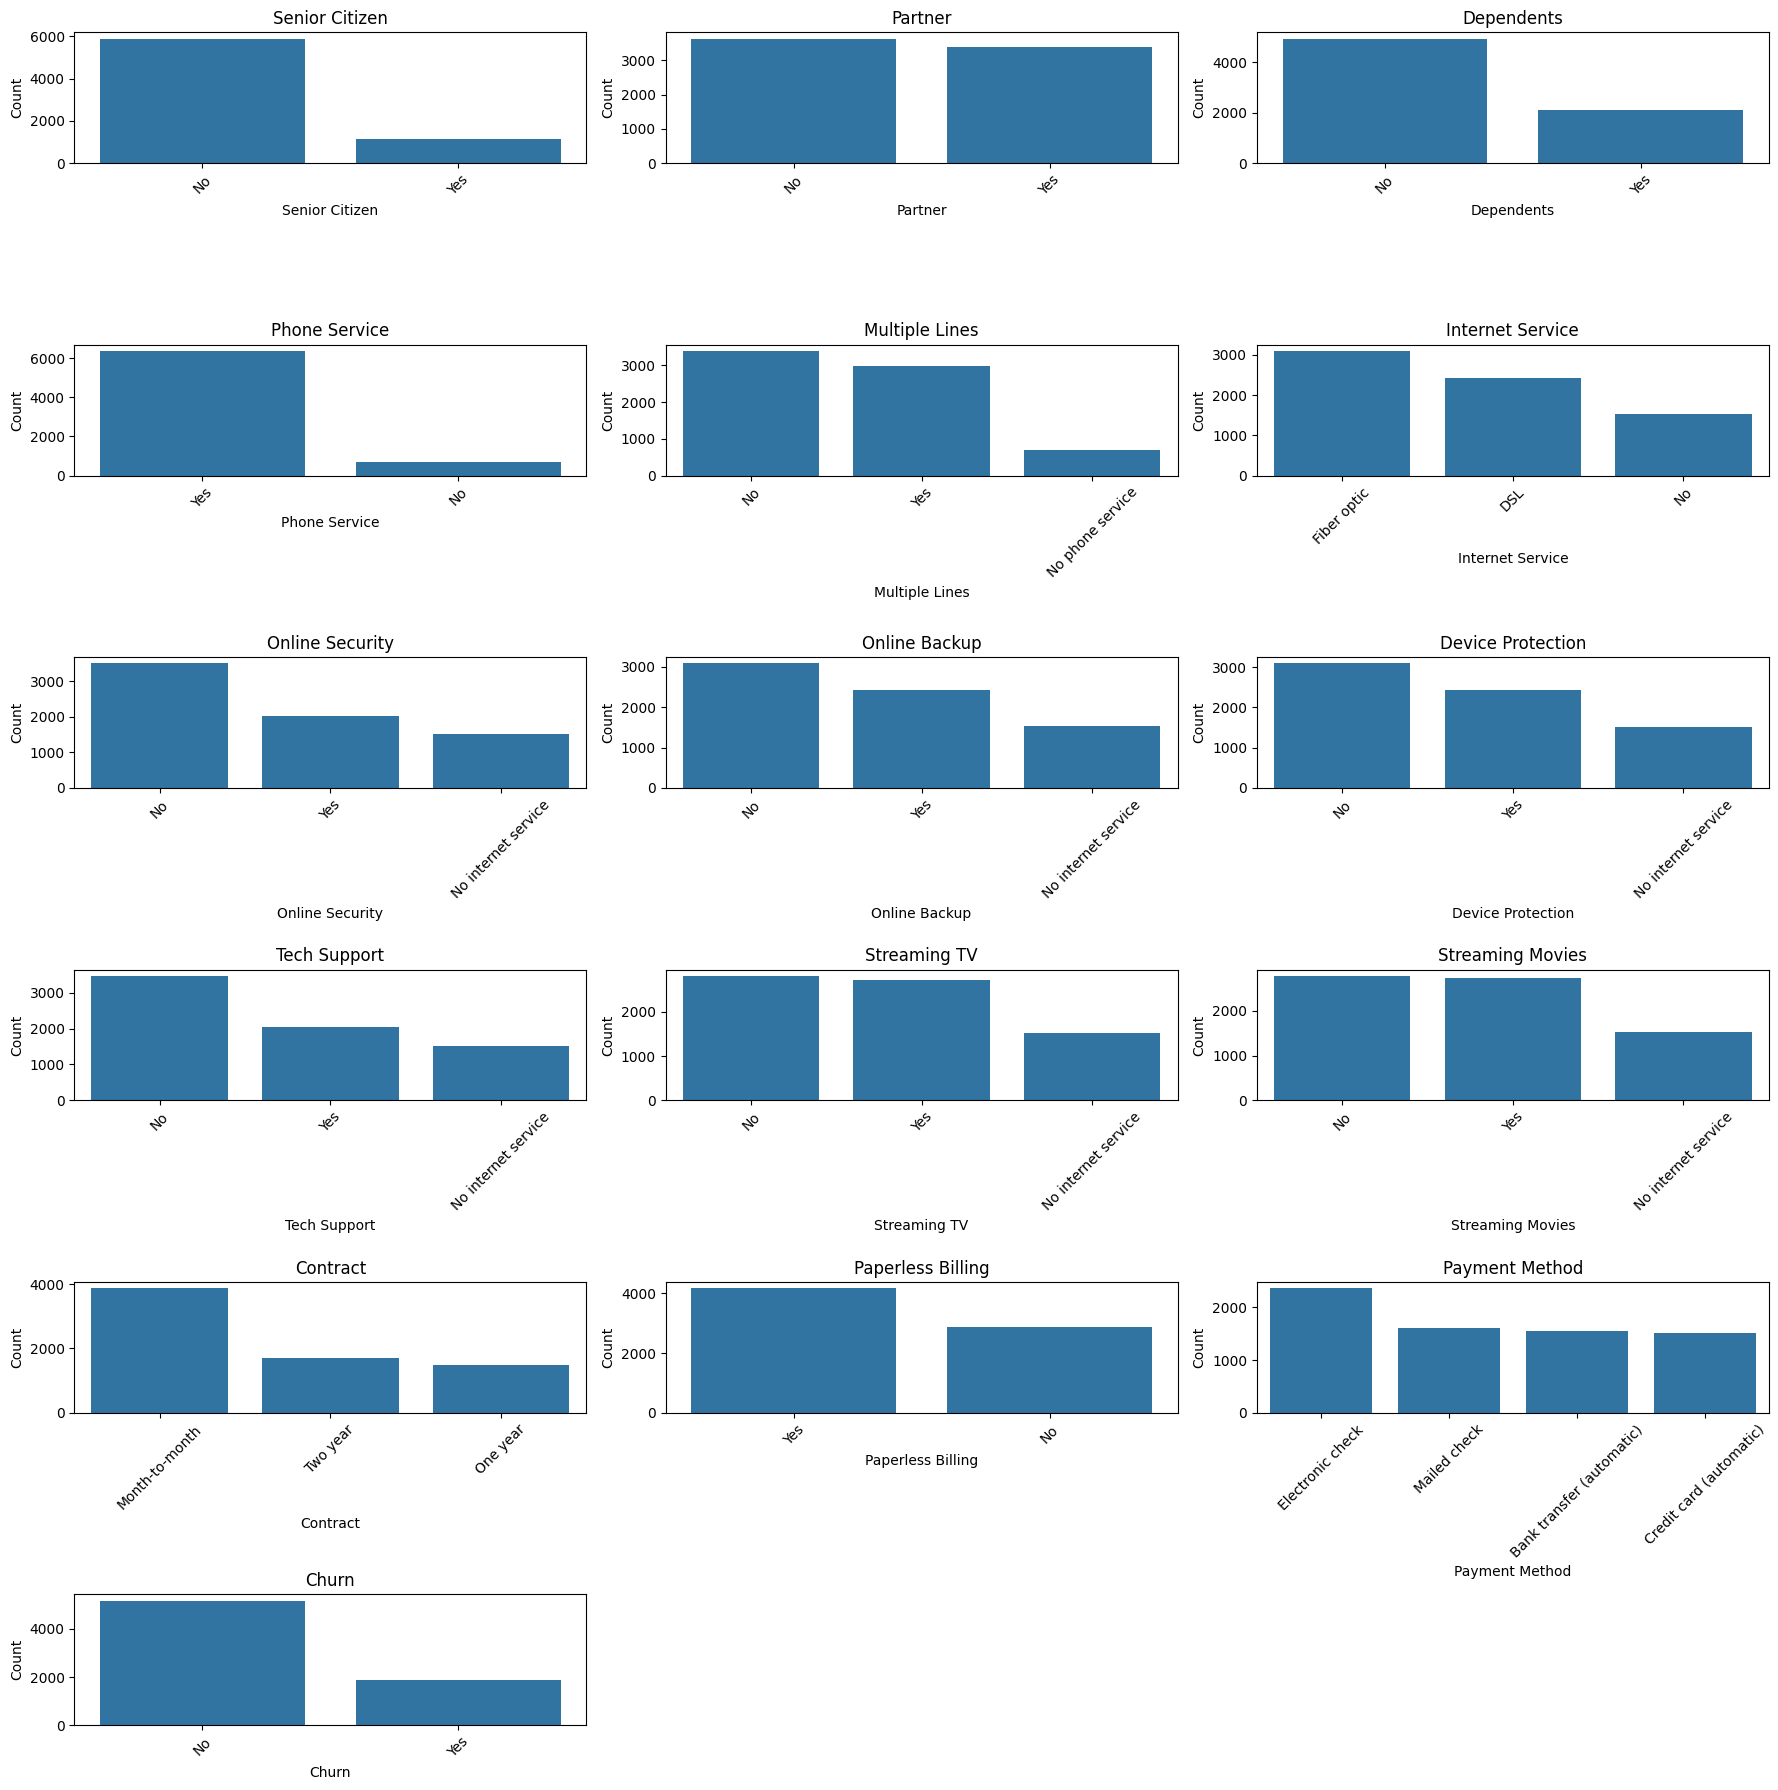

In [23]:
# Find Categorical Columns to plot
cat_cols_to_plot = [col for col in df.select_dtypes(include=['object']).columns 
                    if col not in ['LoyaltyID', 'Customer ID']]

# Set subplots
fig, axes = plt.subplots(6, 3, figsize=(18, 18))
axes = axes.flatten() 

# Make the bar plots
for i, column in enumerate(cat_cols_to_plot):
    sns.countplot(data=df, x=column, ax=axes[i], order=df[column].value_counts().index)
    axes[i].set_title(f"{column}")
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

From the plots of the counts for each feature, we see there is some imbalance for each feature except for Partner. Telecom data tends to have imbalanced data. 

For the time being, we will proceed without taking action to balance the data, as it may be better to have the model work with what may be naturally imbalanced data. If we forcefully balance it, that may introduce biases.

## Plot Distributions of Numerical Features

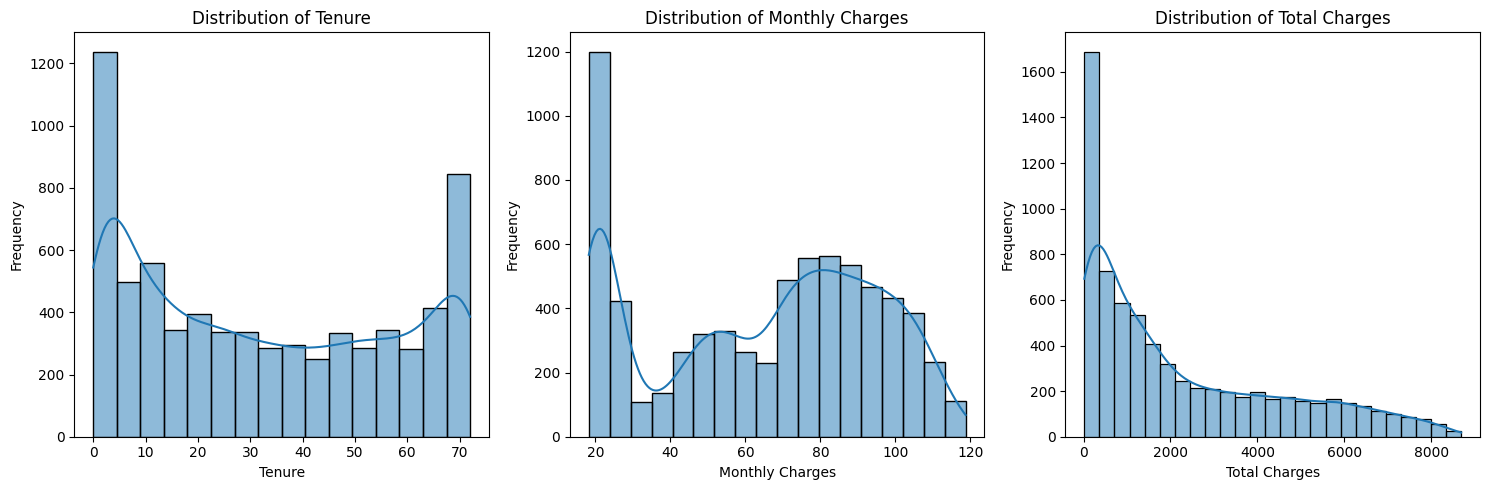

In [24]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The features do not have normal distributions. Tenure and Monthly Charges are multimodal, while Total Charges is right skewed.

# Modeling

We will be using XGBoost as the model to predict customer churn. XGBoost is a tree type model that trains first using a base learning, then computes the errors. It will then train to reduce those errors and compute new errors, repeating the process until a stopping condition is met. XGBoost can be used for both classification and regression tasks. In this case, we have a classification task with imbalanced data and are interested in predicting the minority class. The evaluation metric best suited for the situation is 'aucpr,' the Area Under the PR Curve.

## Transform Numerical Features

In [25]:
# Apply Yeo-Johnson transformation to numerical features
pt = PowerTransformer(method='yeo-johnson')
df[num_cols] = pt.fit_transform(df[num_cols])
df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,-1.644343,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,-1.158541,-1.805206,No
1,152148,5575-GNVDE,No,No,No,0.297205,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,-0.239492,0.256861,No
2,326527,3668-QPYBK,No,No,No,-1.495444,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,-0.342665,-1.381338,Yes
3,845894,7795-CFOCW,No,No,No,0.646327,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),-0.731079,0.235865,No
4,503388,9237-HQITU,No,No,No,-1.495444,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,0.213545,-1.244141,Yes


The data is transformed to take into account the skewed distribution. Since we will be using XGBoost for the model, the data will not need to be scaled.

In [26]:
# Make a copy of the dataframe
df_copy = df.copy()

## Encode Categorical Features

In [27]:
# Find Binary Columns
binary_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Paperless Billing', 'Churn']

# Encoding Binary Columns
for col in binary_cols:
    df[col] = df[col].map({'No': 0, 'Yes': 1})

In [28]:
# Set Additional Service Columns
add_service_cols = [
    'Multiple Lines', 'Online Security', 'Online Backup',
    'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies'
]

# Encoding Additional Service Columns
df = pd.get_dummies(df, columns=add_service_cols, drop_first=True, dtype=int)

In [29]:
# Set Other Columns (Contract and Payment Method)
other_cols = ['Contract', 'Payment Method']

# Encoding Other Columns
df = pd.get_dummies(df, columns=other_cols, drop_first=True, dtype=int)

In [30]:
# Print first 5 rows of data
df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Internet Service,Paperless Billing,Monthly Charges,...,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,318537,7590-VHVEG,0,1,0,-1.644343,No,DSL,1,-1.158541,...,0,0,0,0,0,0,0,0,1,0
1,152148,5575-GNVDE,0,0,0,0.297205,Yes,DSL,0,-0.239492,...,0,0,0,0,0,1,0,0,0,1
2,326527,3668-QPYBK,0,0,0,-1.495444,Yes,DSL,1,-0.342665,...,0,0,0,0,0,0,0,0,0,1
3,845894,7795-CFOCW,0,0,0,0.646327,No,DSL,0,-0.731079,...,1,0,0,0,0,1,0,0,0,0
4,503388,9237-HQITU,0,0,0,-1.495444,Yes,Fiber optic,1,0.213545,...,0,0,0,0,0,0,0,0,1,0


## Check Unique Values for Each Feature

In [31]:
# Print all unique values for each column
for col in df.columns:
    print(f"{col}:")
    print(df[col].unique())

LoyaltyID:
['318537' '152148' '326527' ... '155157' '731782' '353947']
Customer ID:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Senior Citizen:
[0 1]
Partner:
[1 0]
Dependents:
[0 1]
Tenure:
[-1.6443435   0.29720527 -1.49544443  0.64632675 -0.92628704 -0.16269601
 -0.78871081  0.08053824  1.10445427 -0.60622285 -0.44435051  1.00352171
  0.76159927 -0.03718286  1.27288016  0.84473766  1.31927073 -0.2065339
 -0.66440415  0.15530631  0.70462831  1.34219847 -0.39396295  0.04208131
 -1.16936305  0.67564931 -0.72512119  1.29616592  1.12912864  0.58660355
 -0.49640807  1.05444632 -0.34510326  1.20189603 -0.8555903  -1.37221793
  0.19168912  0.78961168  1.15359039  0.95163168 -1.00148358  0.5561775
  0.33125677  0.7332748   0.11826746  1.17784456  0.43037665  1.2494094
  0.22744746  0.9253082   0.3978215   0.36478829  0.52535695 -1.08208957
 -1.26512968  0.26261052  1.22574947 -0.11990163  0.97770058  1.07956199
 -0.55030087 -0.25148998  0.8718688   0.4

The categories were all encoded. Drop_first was used to renmove the first category/dummary variable created to remove multicollinearity issues and prevent the dummy variable trap. 

For example, the device_protection feature took values of 'Yes', 'No', or 'No internet service'. 

The dummy variables in the dataframe are 'Yes' and 'No internet service'. The category of 'No' is implied from values of 0 in the 'Yes' dummy variable.

In [32]:
# Select All Features to be used in the model
features = df.drop(columns=['LoyaltyID', 'Customer ID', 'Phone Service', 'Internet Service'])

## Split the Data

In [33]:
features

,Senior Citizen,Partner,Dependents,Tenure,Paperless Billing,Monthly Charges,Total Charges,Churn,Multiple Lines_No phone service,Multiple Lines_Yes,...,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,1,0,-1.644343,1,-1.158541,-1.805206,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0.297205,0,-0.239492,0.256861,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,-1.495444,1,-0.342665,-1.381338,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0.646327,0,-0.731079,0.235865,0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,-1.495444,1,0.213545,-1.244141,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,-0.078084,1,0.671510,0.299107,0,0,1,...,1,0,1,0,1,1,0,0,0,1
7039,0,1,1,1.342198,1,1.260981,1.565492,0,0,1,...,0,0,1,0,1,1,0,1,0,0
7040,0,1,1,-0.725121,1,-1.167241,-0.854081,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7041,1,1,0,-1.265130,1,0.334312,-0.917097,1,0,1,...,0,0,0,0,0,0,0,0,0,1


## Feature Selection

In [34]:
# Set independent variables
X = features.drop(columns='Churn')

# Set dependent variable
y = features['Churn']

# Split the data at a 80:20 ratio and set the random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Fit the Model without Hyperparameter Tuning

We will first fit an XGBoost model without setting or tuning hyperparameters to get a baseline for performance. The random state is set to 42 to get reproducible results. 

In [35]:
# Initialize the classifier
model = xgb.XGBClassifier(
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test)

### Model Validation

In [36]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7906


The accuracy is good, but the data is imbalanced and the accuracy may be from the model simply predicting 'No' for churn. 

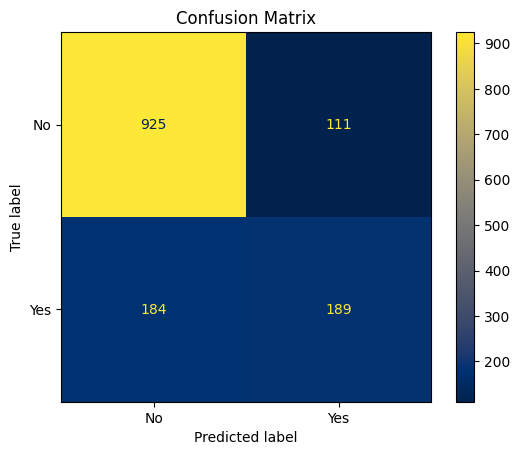

In [37]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No", "Yes"])

# Plot the display
disp.plot(cmap='cividis')
plt.title("Confusion Matrix")
plt.show()

From the Confusion Matrix, the probability of the model making correct predictions for whether a customer will churn is akin to a coin-toss.

In [38]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.51      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



For Not Churn (0):
    
    Precision: 83% of the people predicted not to churn actually did not churn.
    
    Recall: 89% of the people who actually churned were predicted correctly as not churning.
    
    F1 Score: 0.86 means there is a good balance of precision and recall.

For Churn (1):
    
    Precision: 63% of the people predicted to churn actually did churn.
    
    Recall: 51% of churners were predicted correctly by the model.
    
    F1 Score: 0.56 is average. It means there is a tradeoff between missing churners and falsely flagging churners.

In [39]:
# AUC ROC score
y_pred_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8364365418654962


The ROC AUC score is high and means that the model is good at distinguishing between the 2 classes.

## Hyperparameter Tuning

We will use GridSearch to try and identify optimal hyperparameters for the model to try and improve performance.

```
# Find Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 1.0}


## Fit the Model and Get Predictions

In [40]:
# Initialize the classifier
model = xgb.XGBClassifier(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=3,
    n_estimators=50,
    subsample=1.0,
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test)

## Model Validation

In [41]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8091


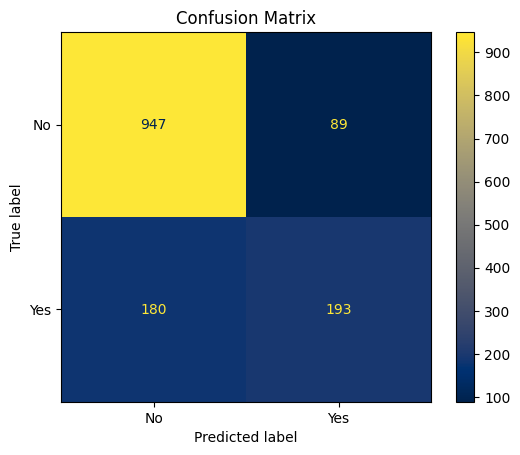

In [42]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No", "Yes"])

# Plot the display
disp.plot(cmap='cividis')
plt.title("Confusion Matrix")
plt.show()

In [43]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.68      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [44]:
# AUC ROC score
y_pred_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.861496837703272


We some small improvements across the board after doing some hyperparameter tuning. However, the improvement is only a few percentage points. 

## Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

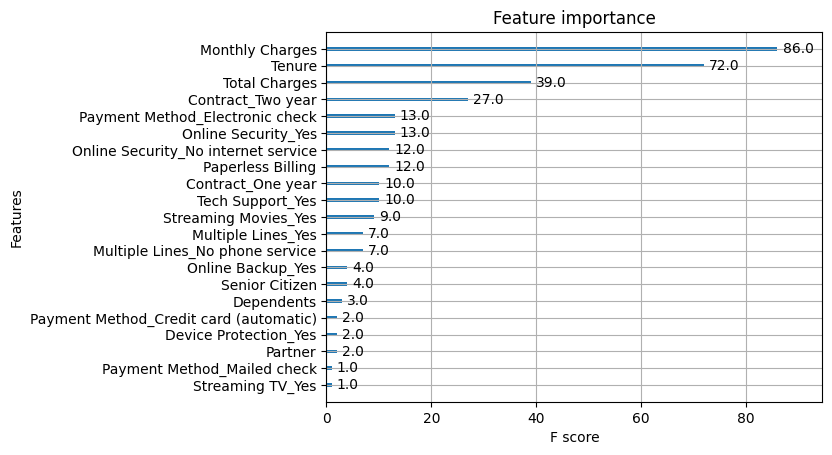

In [45]:
# Plot Feature Importance
xgb.plot_importance(model)

The most important features in the model are Monthly Charges, Total Charges, and Tenure by far. Other features have less importance. If we add up all of the categories, Contract would come close in importance to Total Charges in importance.

# Modeling With Fewer Features

## Drop Unnecessary Features

The model may have too features. Removing some features that aren't necessary may improve performance. Let's remove Partner, Dependents, Phone Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, and Payment Method. 

Phone Service is implied from values in Multiple Lines. Since we are removing the dependent features, we can leave Internet Service instead of removing it like before. 

In [46]:
# Drop Columns
df_copy = df_copy.drop(columns=[
    'LoyaltyID',
    'Customer ID',
    'Partner',
    'Dependents',
    'Phone Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Payment Method',
])

In [47]:
# Print the first 5 rows of the data we'll be working with
df_copy.head()

,Senior Citizen,Tenure,Multiple Lines,Internet Service,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn
0,No,-1.644343,No phone service,DSL,Month-to-month,Yes,-1.158541,-1.805206,No
1,No,0.297205,No,DSL,One year,No,-0.239492,0.256861,No
2,No,-1.495444,No,DSL,Month-to-month,Yes,-0.342665,-1.381338,Yes
3,No,0.646327,No phone service,DSL,One year,No,-0.731079,0.235865,No
4,No,-1.495444,No,Fiber optic,Month-to-month,Yes,0.213545,-1.244141,Yes


## Encode the Categorical Features

In [48]:
# Find Binary Columns
binary_cols = ['Senior Citizen', 'Paperless Billing', 'Churn']

# Encoding Binary Columns
for col in binary_cols:
    df_copy[col] = df_copy[col].map({'No': 0, 'Yes': 1})

# Encoding Other Columns
df_copy = pd.get_dummies(df_copy, columns=['Internet Service', 'Multiple Lines', 'Contract'], drop_first=True, dtype=int)

In [49]:
# Print the first 5 rows of the encoded data frame
df_copy.head()

,Senior Citizen,Tenure,Paperless Billing,Monthly Charges,Total Charges,Churn,Internet Service_Fiber optic,Internet Service_No,Multiple Lines_No phone service,Multiple Lines_Yes,Contract_One year,Contract_Two year
0,0,-1.644343,1,-1.158541,-1.805206,0,0,0,1,0,0,0
1,0,0.297205,0,-0.239492,0.256861,0,0,0,0,0,1,0
2,0,-1.495444,1,-0.342665,-1.381338,1,0,0,0,0,0,0
3,0,0.646327,0,-0.731079,0.235865,0,0,0,1,0,1,0
4,0,-1.495444,1,0.213545,-1.244141,1,1,0,0,0,0,0


## Check Unique Values for Each Feature

In [50]:
# Print all unique values for each column
for col in df_copy.columns:
    print(f"{col}:")
    print(df_copy[col].unique())

Senior Citizen:
[0 1]
Tenure:
[-1.6443435   0.29720527 -1.49544443  0.64632675 -0.92628704 -0.16269601
 -0.78871081  0.08053824  1.10445427 -0.60622285 -0.44435051  1.00352171
  0.76159927 -0.03718286  1.27288016  0.84473766  1.31927073 -0.2065339
 -0.66440415  0.15530631  0.70462831  1.34219847 -0.39396295  0.04208131
 -1.16936305  0.67564931 -0.72512119  1.29616592  1.12912864  0.58660355
 -0.49640807  1.05444632 -0.34510326  1.20189603 -0.8555903  -1.37221793
  0.19168912  0.78961168  1.15359039  0.95163168 -1.00148358  0.5561775
  0.33125677  0.7332748   0.11826746  1.17784456  0.43037665  1.2494094
  0.22744746  0.9253082   0.3978215   0.36478829  0.52535695 -1.08208957
 -1.26512968  0.26261052  1.22574947 -0.11990163  0.97770058  1.07956199
 -0.55030087 -0.25148998  0.8718688   0.4941272   1.02910155 -0.07808394
  0.61664894 -0.29764818  0.89872305  0.81732147  0.00285584 -1.84408848
  0.46247264]
Paperless Billing:
[1 0]
Monthly Charges:
[-1.1585412  -0.23949171 -0.34266505 ... 

## Feature Selection

In [51]:
# Set independent variables
X2 = df_copy.drop(columns='Churn')

# Set dependent variable
y2 = df_copy['Churn']

# Split the data at a 70:30 ratio and set the random state for reproducibility
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

## Hyperparameter Tuning

```
# Find Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X2_train, y2_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}


## Fit the Model

In [52]:
# Initialize the classifier
model2 = xgb.XGBClassifier(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=50,
    subsample=1.0,
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
model2.fit(X2_train, y2_train)

# Predict labels for the test set
y2_pred = model2.predict(X2_test)

## Model Validation

In [53]:
# Accuracy
acc = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8084


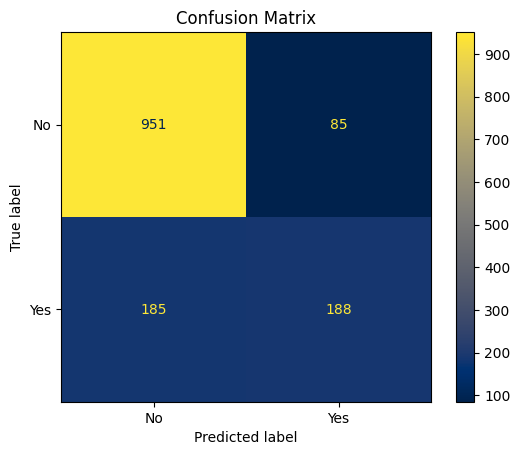

In [54]:
# Create the confusion matrix
cm = confusion_matrix(y2_test, y2_pred)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No", "Yes"])

# Plot the display
disp.plot(cmap='cividis')
plt.title("Confusion Matrix")
plt.show()

In [55]:
# Classification report
print("Classification Report:\n")
print(classification_report(y2_test, y2_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.50      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



This model has similar performance overall compared to the hyperparameter tuned model. Unfortunately, it has a 2% decrease in Recall for churners, which is probably the most important metric for the model. The previous model would be preferred.

In [56]:
# AUC ROC score
y2_pred_prob = model2.predict_proba(X2_test)[:, 1]
roc_auc = roc_auc_score(y2_test, y2_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8616119949900111


The ROC-AUC is slightly higher than the previous model and better distinguishes between classes.

Overall, this model would probably not be preferred over the previous model because we are most interested in correctly predicting churn.

# Balanced Data Model

We will now use Synthetic Minority Oversampling Technique (SMOTE), a technique to deal with imbalanced data by generating some synthetic data for the minorities from existing data. Since the data is imbalanced, let's see if SMOTE brings any improvements to model performance. We will use the feature set from Model 1, as it had the best performance so far.

## Resampling Data Using SMOTE

In [57]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Hyperparameter Tuning

```
# Find Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


## Fit the Model and Get Predictions

## Model Validation

In [58]:
# Set the Hyperparameters for the SMOTE model
smote_model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=10,
    min_child_weight=1,
    n_estimators=100,
    subsample=0.9,
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
smote_model.fit(X_resampled, y_resampled)

# Predict labels for the test set
y_pred_smote = smote_model.predict(X_test)

In [59]:
# Accuracy
acc = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7722


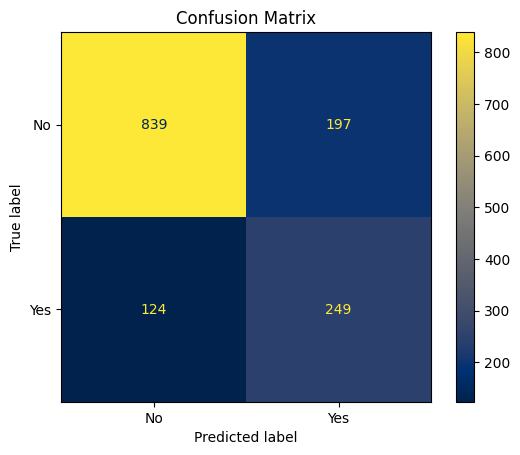

In [60]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_smote)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No", "Yes"])

# Plot the display
disp.plot(cmap='cividis')
plt.title("Confusion Matrix")
plt.show()

In [61]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_smote))

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1036
           1       0.56      0.67      0.61       373

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409



The model after using SMOTE has poor accuracy and recall when predicting whether a customer didn't churn. However, while the precision decreased for churning customers, the recall increased by 15%. 

Overall, accuracy had decreased and the model sacrificed some performance when predicting if a customer didn't churn in exchange for catching more people who actully churned. 

In [62]:
# AUC ROC score
y_pred_prob = smote_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8296306168290084


The ROC AUC score is slightly worse than the previous models but better than the one that did not have hyperparameter tuning done. However, the Score is still high.

# Conclusion

An XGBoost Model was created for this imbalanced Telecom Customer Churn Dataset. The 2 best models were the models that had hyperparameter tuning and SMOTE. The model performed better with all of the reasonable features for predicting churn in the data. Removing features had slightly decreased performance by a negligible amount.

Between the 2 best models, the one with SMOTE makes a tradeoff between correctly predicting which customers will not churn for better performance in identifying customers that do churn. Considering that the customers that do churn are a minority, this model would likely be preferred by business.

7043 observations is rather small and a better model could be made with more data.